# NOTE: The following processes were done on three pickle files: 'chairman.pickle' 'vicechair.pickle', 'governor.pickle'. For this file, we only depict processing on 'governor.pickle'

# Clean Text Data

In [26]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [27]:
# Set display preference
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

## Define Utility Functions

In [28]:
# Functions for map() or apply()

def get_word_count(x):
    '''
    Retun the number of words for the given text x.
    '''
    x = x.replace("[SECTION]", "")
    return len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', x))

In [29]:
def reorganize_df(df, doc_type):
    '''
    Reorganize the loaded dataframe, which has been obrained by FomcGetData for further processing
        - Add type
        - Add word count
        - Copy contents to org_text
        - Remove line breaks from contents in text
        - Split contents by "[SECTION]" to list in text_sections
    '''
    
    if doc_type in ('statement', 'minutes', 'presconf_script', 'meeting_script'):
        is_meeting_doc = True
    elif doc_type in ('speech', 'testimony'):
        is_meeting_doc = False
    else:
        print("Invalid doc_type [{}] is given!".format(doc_type))
        return None
    
    dict = {
        'type': doc_type,
        'date': df['date'],
        'title': df['title'],
        'speaker': df['speaker'],
        'word_count': df['contents'].map(get_word_count),
        'text': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip()),
        'text_sections': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
        'org_text': df['contents']
    }

    new_df = pd.DataFrame(dict)
    print("Shape of the dataframe: ", new_df.shape)
    return new_df

In [30]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    '''
    Returns a list of split text of $split_len with overlapping of $overlap.
    Each item of the list will have around split_len length of text.
    '''
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    return split_df

In [31]:
def remove_short_section(df, min_words=50):
    '''
    Using 'text_sections' of the given dataframe, remove sections having less than min_words.
    It concatenates sections with a space, which exceeds min_words and update 'text'.
    As a fallback, keep a text which concatinates sections having more than 20 words and use it
     if there is no section having more than min_words.
    If there is no sections having more than 20 words, remove the row.
    '''
    new_df = df.copy()
    new_text_list = []
    new_text_section_list = []
    new_wc_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_text = ""
        bk_text = ""
        new_text_section = []
        bk_text_section = []
                
        for section in row['text_sections']:
            num_words = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section))
            if num_words > min_words:
                new_text += " " + section
                new_text_section.append(section)
            elif num_words > 20:
                bk_text += " " + section
                bk_text_section.append(section)
                
        
        new_text = new_text.strip()
        bk_text = bk_text.strip()
        
        if len(new_text) > 0:
            new_text_list.append(new_text)
            new_text_section_list.append(new_text_section)
        elif len(bk_text) > 0:
            new_text_list.append(bk_text)
            new_text_section_list.append(bk_text_section)
        else:
            new_text_list.append("")
            new_text_section_list.append("")
        
        # Update the word count
        new_wc_list.append(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', new_text_list[-1])))
        
    new_df['text'] = new_text_list
    new_df['word_count'] = new_wc_list
    
    return new_df.loc[new_df['word_count'] > 0]

def remove_short_nokeyword(df, keywords = ['rate', 'rates', 'federal fund', 'outlook', 'forecast', 'employ', 'economy'], min_times=2, min_words=50):
    '''
    Drop sections which do not have any one of keywords for min_times times
     before applying remove_short_section()
    '''
    
    new_df = df.copy()
    new_section_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_section = []
                
        for section in row['text_sections']:
            if len(set(section.split()).intersection(keywords)) >= min_times:
                new_section.append(section)
        
        new_section_list.append(new_section)
    
    new_df['text_sections'] = new_section_list
    
    return remove_short_section(new_df, min_words=min_words)

## Load Data

### Speech

In [32]:
# file = open('./data/governor.pickle', 'rb')

file = open('./governor.pickle', 'rb')

speech_df = pickle.load(file)
file.close()

print(speech_df.shape)
speech_df

(749, 4)


,date,contents,speaker,title
1,1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments 96 Conference, Dallas, TexasJune 18, 1996[SECTION][SECTION]It is a pleasure to be here thi...","Governor Edward W. Kelley, Jr.",Developments in electronic money and banking
2,1996-09-08,Monetary Policy Objectives and Strategy[SECTION]I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want ...,Governor Laurence H. Meyer,Monetary policy objectives and strategy
4,1996-10-02,"Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996[SECTION][SECTION]Small Business Is Big Business[SECTION]It is my pleasure to ...",Governor Lawrence B. Lindsey,Small business is big business
7,1996-10-09,"Remarks by Governor Lawrence B. LindseyAt the Community Development Lending Conference, Dallas, TexasOctober 9, 1996[SECTION][SECTION]Here We Go Again?[SECTION]Thank you. It is a pleasure to be h...",Governor Lawrence B. Lindsey,Here we go again?
8,1996-10-11,"Remarks by Governor Lawrence B. LindseyAt the Atlantic Economic Society, Washington, D.C.October 11, 1996[SECTION][SECTION]How To Grow Faster[SECTION]It is my pleasure to be here today to discuss ...",Governor Lawrence B. Lindsey,How to grow faster
...,...,...,...,...
1476,2020-10-01,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...",Governor Michelle W. Bowman,Mortgage Market Regulation and Access to Mortgage Credit
1477,2020-10-01,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...",Governor Lael Brainard,Modernizing and Strengthening CRA Regulations: Hearing from Community Banks
1482,2020-10-15,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...",Governor Lael Brainard,Modernizing and Strengthening CRA Regulations: A Conversation with Minority Depository Institutions
1485,2020-10-20,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...",Governor Lael Brainard,Modernizing and Strengthening CRA Regulations: A Conversation with the Housing Community


In [33]:
# Sample Contents - the 2nd last
print(speech_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monetary Policy Principles and Practice[SECTION]Policy Implementation[SECTION]Reports[SECTION]Review of Monetary Policy Strategy, Tools, and Communications[SECTION]Institution Supervision[SECTION]Reports[SECTION]Reporting Forms[SECTION]Supervision & Regulation Letters[SECTION]Banking Applications & Legal Developments[SECTION]Regulatory Resources[SECTION]Banking & Data Structure[SECTION]Regulations & Statutes[SECTION]Payment Policies[SECTION]Reserve Bank Payment Services & Data[SECTION]Financial Market Utilities & Infrastructures[SECTION]Research, Committees, and Forums[SECTION]Working Papers and Notes[SECTION]Models and Tools[SECTION]Bank Assets and Liabilities[SECTION]Bank Structure Data[SECTION]Business Finance[SECTION]Dealer Financing Terms[SECTION]Exchange Rates and International Data[SECTION]F

## Speech DataFrame

In [34]:
# Reorganize the dataframe
proc_speech_df = reorganize_df(speech_df, 'speech')

Shape of the dataframe:  (749, 8)


In [35]:
# Check the returned dataframe
# Note that rate and decision are not applicable because speech is not at FOMC meeting
proc_speech_df = proc_speech_df.reset_index(drop=True)

(749, 8)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


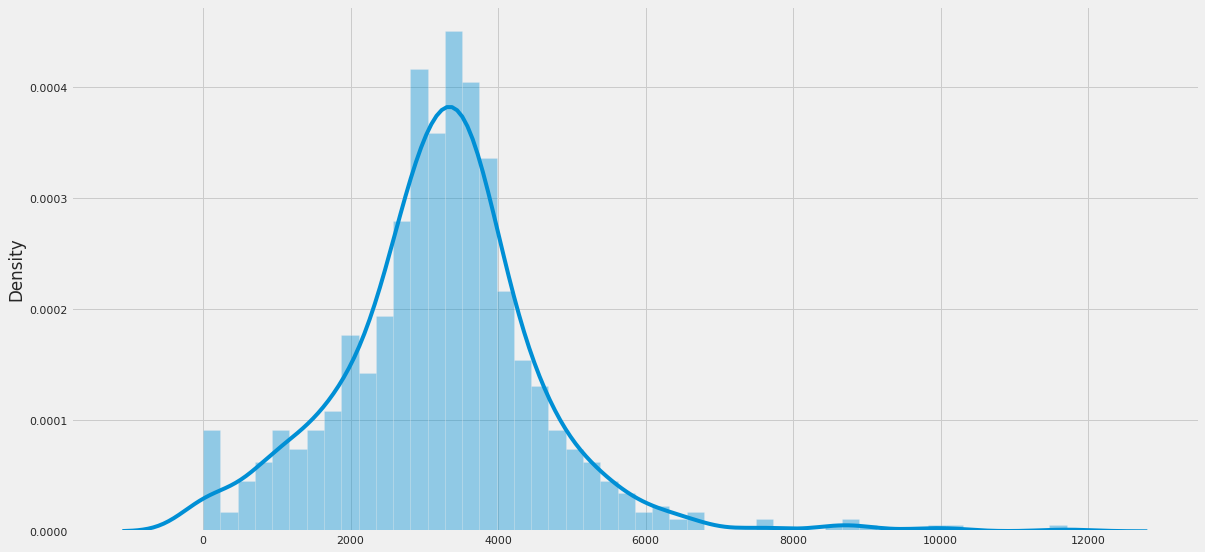

In [36]:
print(proc_speech_df.shape)
sns.distplot(proc_speech_df["word_count"].values, bins=50)

In [37]:
# Check records where speaker is null
proc_speech_df['speaker'].isnull().sum()

0

In [38]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_speech_df = remove_short_section(proc_speech_df, min_words=50)
proc_speech_df


,type,date,title,speaker,word_count,text,text_sections,org_text
0,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",2658,"It is a pleasure to be here this afternoon to provide the Federal Reserves perspective on recent developments in the field of electronic money and banking. To begin, let me remind you...","[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments 96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon t...","Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments 96 Conference, Dallas, TexasJune 18, 1996[SECTION][SECTION]It is a pleasure to be here thi..."
1,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,2728,I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emphasize the importance of setting monetary ...,"[Monetary Policy Objectives and Strategy, I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emp...",Monetary Policy Objectives and Strategy[SECTION]I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want ...
2,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,1999,"A fair question might be, what is the nations central bank doing sponsoring aconference on small business? Well, let me be clear about one thing, neither I nor mycolleagues from the Fed are goin...","[Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996, , Small Business Is Big Business, It is my pleasure to be here today at the...","Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996[SECTION][SECTION]Small Business Is Big Business[SECTION]It is my pleasure to ..."
3,speech,1996-10-09,Here we go again?,Governor Lawrence B. Lindsey,3604,Thank you. It is a pleasure to be here today to discuss some of the challenges that lie ahead in the areas of economic opportunity and community development. Frankly its a pleasure to be anywhe...,"[Remarks by Governor Lawrence B. LindseyAt the Community Development Lending Conference, Dallas, TexasOctober 9, 1996, , Here We Go Again?, Thank you. It is a pleasure to be here today to discuss...","Remarks by Governor Lawrence B. LindseyAt the Community Development Lending Conference, Dallas, TexasOctober 9, 1996[SECTION][SECTION]Here We Go Again?[SECTION]Thank you. It is a pleasure to be h..."
4,speech,1996-10-11,How to grow faster,Governor Lawrence B. Lindsey,4381,"I can well understand the interest in this issue. Even though employment is high andinflation is low, the growth of real incomes for American workers has been virtually non-existent. The level ...","[Remarks by Governor Lawrence B. LindseyAt the Atlantic Economic Society, Washington, D.C.October 11, 1996, , How To Grow Faster, It is my pleasure to be here today to discuss some of the most imp...","Remarks by Governor Lawrence B. LindseyAt the Atlantic Economic Society, Washington, D.C.October 11, 1996[SECTION][SECTION]How To Grow Faster[SECTION]It is my pleasure to be here today to discuss ..."
...,...,...,...,...,...,...,...,...
744,speech,2020-10-01,Mortgage Market Regulation and Access to Mortgage Credit,Governor Michelle W. Bowman,917,"Throughout the response to the pandemic, community bankers have continued to serve as the primary source of credit to small businesses and have continued to provide economic and financial support ...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Mar

In [39]:
speech_chair_df = proc_speech_df

### Split contents to max 200 words

In [40]:
speech_split_df = get_split_df(speech_chair_df)
speech_split_df.reset_index(drop=True, inplace=True)
print(speech_split_df.shape)
speech_split_df


(15408, 8)


,type,date,title,speaker,word_count,text,text_sections,org_text
0,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",200,It is a pleasure to be here this afternoon to provide the Federal Reserves perspective on recent developments in the field of electronic money and banking To begin let me remind you that progress ...,"[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments 96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon t...","Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments 96 Conference, Dallas, TexasJune 18, 1996[SECTION][SECTION]It is a pleasure to be here thi..."
1,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",200,account for a very small fraction In contrast for the major money and securities markets in this country electronic payments are the rule rather than the exception Settlements for these markets ge...,"[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments 96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon t...","Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments 96 Conference, Dallas, TexasJune 18, 1996[SECTION][SECTION]It is a pleasure to be here thi..."
2,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",200,and in the development of new home banking products If the past is any guide consumer acceptance and use of new payment and banking technologies will grow slowly and we can be certain that many of...,"[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments 96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon t...","Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments 96 Conference, Dallas, TexasJune 18, 1996[SECTION][SECTION]It is a pleasure to be here thi..."
3,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",200,handed preemptive attempts at regulating these products and the competitive process before significant social risks have been demonstrated would likely handicap innovation for no compelling reason...,"[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments 96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon t...","Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments 96 Conference, Dallas, TexasJune 18, 1996[SECTION][SECTION]It is a pleasure to be here thi..."
4,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",200,such as consumer privacy and industry competition the policy issues being raised in the current debate about electronic payments are the same as those analyzed in the by the national EFT Commissio...,"[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments 96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon t...","Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments 96 Conference, Dallas, TexasJune 18, 1996[SECTION][SECTION]It is a pleasure to be here thi..."
...,...,...,...,...,...,...,...,...
15403,speech,2020-10-21,Achieving a Broad-Based and Inclusive Recovery,Governor Lael Brainard,200,Inflation expectations are difficult to measure directly so I generally consult a set of indicators to provide a more complete picture than any one measure on its own Changes in expectations repor...,"[The Federal Reserve, the central bank of the United States, provides t

### Filter out by keyword

In [41]:
# Keep sections having keywords and long enough
speech_keyword_df = remove_short_nokeyword(speech_chair_df)
speech_keyword_df.reset_index(drop=True, inplace=True)
print(speech_keyword_df.shape)
speech_keyword_df


(363, 8)


,type,date,title,speaker,word_count,text,text_sections,org_text
0,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,896,"Economic theory, in the form of the long-run neutrality of money, tells us that monetary policy cannot affect the level or growth rate of output in the long run. So dont saddle monetary policy wi...","[Economic theory, in the form of the long-run neutrality of money, tells us that monetary policy cannot affect the level or growth rate of output in the long run. So dont saddle monetary policy w...",Monetary Policy Objectives and Strategy[SECTION]I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want ...
1,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,470,"But, even those businesses which do not become industrial behemoths still have a vitalrole to play. Small businesses build our homes and unclog the drains when they get full, theymonitor our heal...","[But, even those businesses which do not become industrial behemoths still have a vitalrole to play. Small businesses build our homes and unclog the drains when they get full, theymonitor our hea...","Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996[SECTION][SECTION]Small Business Is Big Business[SECTION]It is my pleasure to ..."
2,speech,1996-10-09,Here we go again?,Governor Lawrence B. Lindsey,470,Without any question the most important economic development has been a decline in the underlying rate of inflation and the consequent decline in medium- and long-term interest rates. Lets do the...,[Without any question the most important economic development has been a decline in the underlying rate of inflation and the consequent decline in medium- and long-term interest rates. Lets do th...,"Remarks by Governor Lawrence B. LindseyAt the Community Development Lending Conference, Dallas, TexasOctober 9, 1996[SECTION][SECTION]Here We Go Again?[SECTION]Thank you. It is a pleasure to be h..."
3,speech,1996-10-11,How to grow faster,Governor Lawrence B. Lindsey,544,"There is, however, one option that from time immemorial always seems to find its wayinto the political discourse: print money. This year we have frequently heard from variousquarters that it is ...","[There is, however, one option that from time immemorial always seems to find its wayinto the political discourse: print money. This year we have frequently heard from variousquarters that it is...","Remarks by Governor Lawrence B. LindseyAt the Atlantic Economic Society, Washington, D.C.October 11, 1996[SECTION][SECTION]How To Grow Faster[SECTION]It is my pleasure to be here today to discuss ..."
4,speech,1997-01-05,The role of structural macroeconomic models,Governor Laurence H. Meyer,1230,"There are two important differences from the private sector use of models for forecasting, at least based on my experience at LHM&A. First, the staff is not truly making a forecast of economic ac...","[There are two important differences from the private sector use of models for forecasting, at least based on my experience at LHM&A. First, the staff is not truly making a forecast of economic a...",[SECTION]The Role for Structural Macroeconomic Models[SECTION]I am in the middle of my third interesting and active encounter with the development and/or use of macroeconometric models for forecas...
...,...,...,...,...,...,...,...,...
358,speech,2020-01-16,The Outlook for Housing,Governor Michelle W. Bowman,675,Few sectors are as central to the success of our economy and the lives of American families as housing. If we include the amount families spend on shelter each month as well as the construction of...,[Few sectors are as central to the success of our economy and the lives of American families as housing. If we include the amount families spend on shelter each month as well as the construction o...,

In [42]:
# Drop text_sections
speech_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

In [43]:
speech_chair_df['text'][0]

'It is a pleasure to be here this afternoon to provide     the Federal Reserves perspective on recent developments in the     field of electronic money and banking.  To begin, let me remind     you that progress in the retail electronic banking sector so far     has been slow in the United States.  Twenty years ago, a national     Commission was appointed by the Congress to study many of the     issues surrounding emerging electronic funds transfer systems,     particularly as they were seen to affect consumers and the     general public.  The assumption at that time was that the use of     currency and checks in the United States would rapidly disappear.     Indeed, the creation of the Automated Clearing House system and     NACHA have their roots in this era of our history.  Yet today,     paper currency and checks are still used for the overwhelming     majority of consumer payments, while electronic transfers, such     as those made over the ACH, account for a very small fraction. 

In [44]:
speech_split_df['text'][0]

'It is a pleasure to be here this afternoon to provide the Federal Reserves perspective on recent developments in the field of electronic money and banking To begin let me remind you that progress in the retail electronic banking sector so far has been slow in the United States Twenty years ago a national Commission was appointed by the Congress to study many of the issues surrounding emerging electronic funds transfer systems particularly as they were seen to affect consumers and the general public The assumption at that time was that the use of currency and checks in the United States would rapidly disappear Indeed the creation of the Automated Clearing House system and NACHA have their roots in this era of our history Yet today paper currency and checks are still used for the overwhelming majority of consumer payments while electronic transfers such as those made over the ACH account for a very small fraction In contrast for the major money and securities markets in this country ele

In [45]:
speech_keyword_df['text'][0]

'Economic theory, in the form of the long-run neutrality of money, tells us that monetary policy cannot affect the level or growth rate of output in the long run.  So dont saddle monetary policy with responsibilities for stimulating the growth of productive capacity.  If it were easy to produce more long-run growth simply by printing money we would have monetized our way to dramatically higher living standards a long time ago. What monetary policy does do, according to economic theory, is set the rate of inflation in the long run.  As I said in my opening statement in my confirmation hearings, when it comes to assigning responsibility for inflation, the buck literally stops at the Federal Reserve. Price stability is therefore the singular and unique long-run objective for monetary policy.  Fiscal policy, on the other hand, can be an instrument of growth policy, through its effect on national saving via the structural budget deficit, through incentive effects on work, saving and investm

## Save the training data

In [46]:
def save_data(df, file_name, dir_name='./data/'):
    '''
    Save the given df to pickle file and csv file in the given directory.
    '''
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print("Data Saved to a pickle file in {} !".format(dir_name))
    

In [47]:
save_data(speech_split_df, 'governor_speech_split')
save_data(speech_keyword_df, 'governor_speech_keyword')

Data Saved to a pickle file in ./data/ !
Data Saved to a pickle file in ./data/ !


## Testing Pickle

In [48]:
import pickle
f = open('./data/governor_speech_keyword.pickle', 'rb')
mydict = pickle.load(f)
f.close()

In [49]:
mydict

,type,date,title,speaker,word_count,text
0,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,896,"Economic theory, in the form of the long-run neutrality of money, tells us that monetary policy cannot affect the level or growth rate of output in the long run. So dont saddle monetary policy wi..."
1,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,470,"But, even those businesses which do not become industrial behemoths still have a vitalrole to play. Small businesses build our homes and unclog the drains when they get full, theymonitor our heal..."
2,speech,1996-10-09,Here we go again?,Governor Lawrence B. Lindsey,470,Without any question the most important economic development has been a decline in the underlying rate of inflation and the consequent decline in medium- and long-term interest rates. Lets do the...
3,speech,1996-10-11,How to grow faster,Governor Lawrence B. Lindsey,544,"There is, however, one option that from time immemorial always seems to find its wayinto the political discourse: print money. This year we have frequently heard from variousquarters that it is ..."
4,speech,1997-01-05,The role of structural macroeconomic models,Governor Laurence H. Meyer,1230,"There are two important differences from the private sector use of models for forecasting, at least based on my experience at LHM&A. First, the staff is not truly making a forecast of economic ac..."
...,...,...,...,...,...,...
358,speech,2020-01-16,The Outlook for Housing,Governor Michelle W. Bowman,675,Few sectors are as central to the success of our economy and the lives of American families as housing. If we include the amount families spend on shelter each month as well as the construction of...
359,speech,2020-02-10,Empowering Community Banks,Governor Michelle W. Bowman,138,"My colleagues and I on the Federal Open Market Committee had our most recent meeting about two weeks ago, when we decided to keep our target range for the federal funds rate unchanged at 1-1/2 to ..."
360,speech,2020-02-21,Monetary Policy Strategies and Tools When Inflation and Interest Rates Are Low,Governor Lael Brainard,675,"Looking AheadThe current generation of central bankers faces a different core challenge than the last generation, with substantially smaller scope for cutting interest rates to buffer the economy ..."
361,speech,2020-07-14,Navigating Monetary Policy through the Fog of COVID,Governor Lael Brainard,395,"Finally, in keeping with the global nature of the pandemic, foreign developments could impinge on the U.S. recovery. The International Monetary Fund estimates that real global gross domestic produ..."
